In [1]:
#Import necessary libraries
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
import sys
print(sys.executable)

c:\Users\13124\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
#Load Airbnb Listings 
nyc_airbnb_listings = pd.read_csv('listings.csv')

In [4]:
#Load Airbnb Reviews 
nyc_airbnb_reviews = pd.read_csv('reviews.csv')

In [5]:
#Load Airbnb Reviews
nyc_rent_prices = pd.read_csv('Zip_zori_uc_sfrcondomfr_sm_month.csv')

DATA CLEANING

In [6]:

#Separating the date columns from the non-date columns in the rent prices DataFrame.
cols = nyc_rent_prices.columns
usable_cols = cols[0:9]
dates_cols = cols[9:]
print(dates_cols) 

Index(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
       ...
       '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
       '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30'],
      dtype='object', length=131)


In [7]:
#Melting the rent prices DataFrame to transform it from wide format to long format.
nyc_rent_prices = pd.melt(nyc_rent_prices, id_vars=usable_cols, value_vars=dates_cols, var_name='date', value_name='rent_price')                    

In [8]:
#Checking the data types of each column in the rent prices DataFrame. Date column is an object format and needs to be converted to a datetime format.
nyc_rent_prices.dtypes

RegionID        int64
SizeRank        int64
RegionName      int64
RegionType     object
StateName      object
State          object
City           object
Metro          object
CountyName     object
date           object
rent_price    float64
dtype: object

In [9]:
#Reformat as datetime

nyc_rent_prices['date'] = pd.to_datetime(nyc_rent_prices['date'], format = '%Y-%m-%d')

#Keep only year and month in date column

nyc_rent_prices['date'] = nyc_rent_prices['date'].dt.to_period('M')

In [10]:
print(usable_cols)





Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'],
      dtype='object')


In [12]:
#Filter reviews to only include 2022 to September 2025
nyc_airbnb_reviews['date'] = pd.to_datetime(nyc_airbnb_reviews['date'])


#Group by month and count
monthly_counts = nyc_airbnb_reviews.groupby(nyc_airbnb_reviews['date'].dt.to_period('M')).size()
print(monthly_counts)

date
2009-05        1
2009-06        2
2009-07        3
2009-08        4
2009-10        7
           ...  
2025-08    13618
2025-09    14133
2025-10    14050
2025-11    11446
2025-12      557
Freq: M, Length: 199, dtype: int64


<Figure size 1200x600 with 0 Axes>

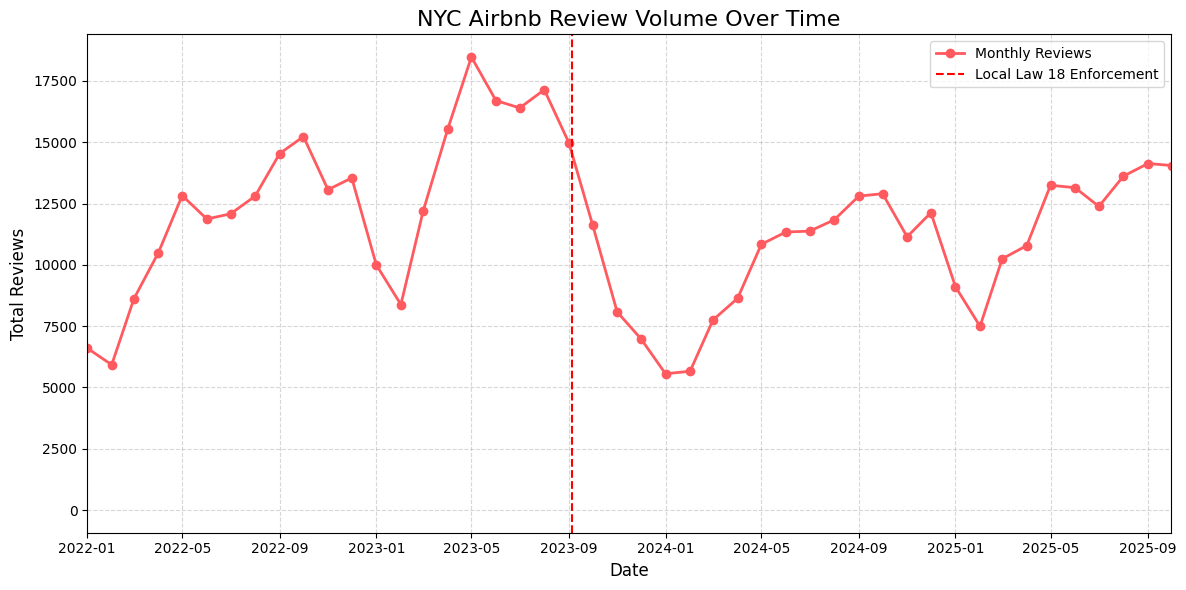

In [13]:
plt.figure(figsize=(12, 6))

x_values = monthly_counts.index
y_values = monthly_counts.values

if isinstance(monthly_counts.index, pd.PeriodIndex):
    x_values = x_values.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(x_values, 
         y_values, 
         marker='o', 
         color='#FF5A5F',  # Airbnb Red
         linewidth=2,
         label='Monthly Reviews')

# Set x-axis limits to 2022-01-01 to 2025-09-30
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2025-09-30'))

plt.axvline(pd.Timestamp('2023-09-05'), color='red', linestyle='--', label='Local Law 18 Enforcement')

# 5. Labels and Titles
plt.title("NYC Airbnb Review Volume Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Reviews", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 6. Show it
plt.tight_layout()
plt.show()

In [15]:
print(monthly_counts.dtypes)

int64


In [16]:
df_style = monthly_counts.to_frame(name='Review Count')

if isinstance(df_style.index, pd.PeriodIndex):
    septembers = df_style[df_style.index.month == 9].copy()
else:
    septembers = df_style[df_style.index.month == 9].copy()

septembers['Change'] = septembers['Review Count'].diff() # The raw number drop
septembers['% Change'] = septembers['Review Count'].pct_change() # The percentage drop

styled_table = (septembers.style
    .format({
        'Review Count': '{:,.0f}',    # Comma for thousands (e.g. 15,000)
        'Change': '{:+,.0f}',         # Force +/- sign (e.g. -500)
        '% Change': '{:+.1%}'         # Percentage format (e.g. -15.5%)
    })
    .text_gradient(cmap='RdYlGn', subset=['% Change'], vmin=-0.5, vmax=0.5) # Color scale
    .set_caption("Year-Over-Year Review Changes (September Only)")
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
)

# 5. Display
styled_table

,Review Count,Change,% Change
date,,,
2010-09,73,+nan,+nan%
2011-09,250,+177,+242.5%
2012-09,392,+142,+56.8%
2013-09,759,+367,+93.6%
2014-09,"1,454",+695,+91.6%
2015-09,"3,131","+1,677",+115.3%
2016-09,"4,953","+1,822",+58.2%
2017-09,"6,623","+1,670",+33.7%
2018-09,"8,641","+2,018",+30.5%


In [18]:
nyc_map = gpd.read_file("nyc_zip_shapefile.shp")

nyc_map.plot()

DataSourceError: Unable to open nyc_zip_shapefile.shx or nyc_zip_shapefile.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.